# How to use pre-trained models
Tensorflow에서 pre-trained된 model을 활용하는 방법에 대하여 정리, 이 때 graph를 그리는 code와 `ckpt` file은 [TensorFlow Models](https://github.com/tensorflow/models) 에서 제공하는 것들 중 `tf.contrib.slim` 으로 작성된 것을 활용하며, 이 예제에서는 [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/) 데이터에 대해서 학습된 vgg16 model을 활용한다.

* Reference
    + https://github.com/tensorflow/models/tree/master/research/slim
    + https://nbviewer.jupyter.org/github/modulabs/modu-tensorflow/blob/master/week04/01_vgg_slim.ipynb
    + https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a (ImageNet class info)
    
### Setup
1. 필요한 package들을 import하고, test를 하기위한 image를 load한다. 
2. image를 vgg16 model에 inference 할 수 있도록 (224,224,3)으로 resize

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pprint import pprint
%matplotlib inline

slim = tf.contrib.slim

In [2]:
img = Image.open('./dog.png')
img_resized = img.resize((224,224))
img = np.asarray(img)[:,:,:3]
img_resized = np.asarray(img_resized)[:,:,:3]
print(img.shape, img_resized.shape)

(478, 480, 3) (224, 224, 3)


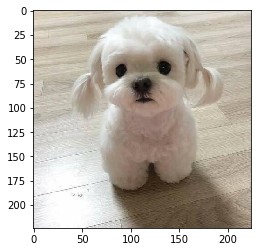

In [3]:
# 누가봐도 말티즈!
img_resized = img_resized.astype(np.float32)
plt.imshow(img_resized / 255)

In [4]:
# 사람이 읽을 수 있는 imagenet 1000개 label의 목록을 가져옴
with open('./imagenet1000_clsid_to_human.txt', mode = 'r') as io:
    label_table = eval(io.read())

In [5]:
type(label_table)

dict

### Step 1
먼저 [TensorFlow Models](https://github.com/tensorflow/models) repository를 clone

```bash
$ git clone git@github.com:tensorflow/models.git
```

그 이후, `models/research/slim/nets` 에서 graph를 생성하는 script를 활용하기위해서 python script 또는 ipynb에 `sys.path.append` function를 이용하여 path를 추가한다.

In [6]:
print(os.getcwd())
pprint(sys.path)

/Users/kbs/Documents/dev/tmp
['',
 '/usr/local/var/pyenv/versions/3.6.5/lib/python36.zip',
 '/usr/local/var/pyenv/versions/3.6.5/lib/python3.6',
 '/usr/local/var/pyenv/versions/3.6.5/lib/python3.6/lib-dynload',
 '/usr/local/var/pyenv/versions/3.6.5/envs/tensorflow/lib/python3.6/site-packages',
 '/usr/local/var/pyenv/versions/3.6.5/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions',
 '/Users/kbs/.ipython']


아래의 코드로 path를 추가하고, 확인한다.

In [7]:
sys.path.append('/Users/kbs/Documents/dev/tmp/models/research/slim/')
pprint(sys.path)

['',
 '/usr/local/var/pyenv/versions/3.6.5/lib/python36.zip',
 '/usr/local/var/pyenv/versions/3.6.5/lib/python3.6',
 '/usr/local/var/pyenv/versions/3.6.5/lib/python3.6/lib-dynload',
 '/usr/local/var/pyenv/versions/3.6.5/envs/tensorflow/lib/python3.6/site-packages',
 '/usr/local/var/pyenv/versions/3.6.5/envs/tensorflow/lib/python3.6/site-packages/IPython/extensions',
 '/Users/kbs/.ipython',
 '/Users/kbs/Documents/dev/tmp/models/research/slim/']


`sys.path.append` function으로 `models/research/slim` 에 대한 절대 경로를 추가하면 아래와 같이 여러 model을 `import` 할 수 있다. 여기에서는 `tf.train.Saver` class의 instance에서 `restore` method로 `ckpt` 를 재사용할 것이므로, 아래와 같이 drop out에 관련된 argument인 `is_training` , `dropout_keep_prob` 에 inference에 적절한 값을 전달한다.

In [8]:
from nets import vgg
X = tf.placeholder(dtype = tf.float32, shape = [None, 224, 224, 3])
score, end_points= vgg.vgg_16(inputs = X, num_classes = 1000, is_training = False, dropout_keep_prob=1.)

아래의 코드로 return된 것이 무엇인지 확인한다. inferene를 위해서는 `score` 가 가리키고 있는 것을 활용하면된다.

In [9]:
print(score)
pprint(end_points)

Tensor("vgg_16/fc8/squeezed:0", shape=(?, 1000), dtype=float32)
OrderedDict([('vgg_16/conv1/conv1_1',
              <tf.Tensor 'vgg_16/conv1/conv1_1/Relu:0' shape=(?, 224, 224, 64) dtype=float32>),
             ('vgg_16/conv1/conv1_2',
              <tf.Tensor 'vgg_16/conv1/conv1_2/Relu:0' shape=(?, 224, 224, 64) dtype=float32>),
             ('vgg_16/pool1',
              <tf.Tensor 'vgg_16/pool1/MaxPool:0' shape=(?, 112, 112, 64) dtype=float32>),
             ('vgg_16/conv2/conv2_1',
              <tf.Tensor 'vgg_16/conv2/conv2_1/Relu:0' shape=(?, 112, 112, 128) dtype=float32>),
             ('vgg_16/conv2/conv2_2',
              <tf.Tensor 'vgg_16/conv2/conv2_2/Relu:0' shape=(?, 112, 112, 128) dtype=float32>),
             ('vgg_16/pool2',
              <tf.Tensor 'vgg_16/pool2/MaxPool:0' shape=(?, 56, 56, 128) dtype=float32>),
             ('vgg_16/conv3/conv3_1',
              <tf.Tensor 'vgg_16/conv3/conv3_1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>),
             ('vgg_16/co

학습된 weight들을 사용했을 때와 비교하기위해서, `tf.global_variables_initializer` 로 weight들을 초기화하여 label을 예측해본다. 역시나 제대로 분류해내지 못한다.

In [10]:
tf.set_random_seed(777) # 행운이 깃들기를!
sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess = tf.Session(config = sess_config)
sess.run(tf.global_variables_initializer())

In [11]:
ybefore = sess.run(score, feed_dict = {X : img_resized.reshape(-1,224,224,3)})
print(label_table.get(np.argmax(ybefore, axis = -1)[0]))

tape player


### Step 2
[TensorFlow-Slim image classification model library](https://github.com/tensorflow/models/tree/master/research/slim) 에서는 [ILSVRC-2012-CLS](http://www.image-net.org/challenges/LSVRC/2012/) 데이터에 대하여 학습한 각 model들의 weight를 `ckpt` 파일로 제공하고 있다. 위에서 사용한 model에 알맞는 `ckpt` 파일을 `tf.train.Saver` 를 이용하여 restore 하면된다.
여기에서는 `vgg_16` 을 활용하였으므로, 해당 모델의 `ckpt` 파일을 다운받는다.

In [12]:
# pre-trained directory에 넣어 두었다.
os.listdir()

['dog.png',
 '.DS_Store',
 'imagenet1000_clsid_to_human.txt',
 'vgg_16_2016_08_28.tar.gz',
 'pre-trained',
 'multithread_race_condition.py',
 'models',
 'multithread.py',
 'How to use pre-trained models.ipynb',
 '.ipynb_checkpoints']

`tf.train.Saver` class의 instance를 생성하고, instance의 restore method를 활용하여 `ckpt` 파일의 형태로 저장된 학습된 weight들을 선언해둔 graph에 restore한다.

In [13]:
saver = tf.train.Saver()
saver.restore(sess = sess, save_path = './pre-trained/vgg_16.ckpt')

INFO:tensorflow:Restoring parameters from ./pre-trained/vgg_16.ckpt


학습된 weight들을 사용하면 model이 제대로 이미지를 말티즈로 분류해내는 것을 확인할 수 있다.

In [14]:
yafter = sess.run(score, feed_dict = {X : img_resized.reshape(-1,224,224,3)})
print(label_table.get(np.argmax(yafter, axis = -1)[0]))

Maltese dog, Maltese terrier, Maltese
